## Background y descripción del reto

«Aproximadamente 300 sensores están conectados al cohete y al lanzador móvil para detectar, registrar y transmitir la información». SpaceX está lanzando una nueva cadena de cohetes con un nuevo propósito de negocio, rocket-commerce. Para poder conseguirlo, Elon Musk quiere predecir el estado de los cohetes para poder ajustar costes de forma dinámica. Para ello nos ha proporcionado los datos de varios sensores y su estado. ¿El objetivo? Crea un modelo que sea capaz de predecir el estado.

El objetivo de este reto será ayudar a Elon realizando el modelado predictivo a partir de un dataset que contiene las mediciones hechas por sus sensores y tipos.

Variables del dataset:

 Features: El dataset contiene 6 features en 6 columnas, que son los parámetros medidos de los diferentes sensores. Estos corresponden a las vibraciones detectadas en el cohete.

 Target: El target corresponde al 'label' que clasifica los tipos de estados del cohete en función de los features medidos por los sensores.

   * Target 0 corresponde a Estable
   * Target 1 corresponde a Turbulencia Ligera
   * Target 2 corresponde a Turbulencia Moderada
   * Target 3 corresponde a Turbulencia Severa
   * Target 4 corresponde a Turbulencia Extrema

El objetivo del reto será realizar un modelo predictivo que permita conocer el tipo de erupción que tendrá un cohete en función de las vibraciones medidas por los sensores.

Una vez se haya hecho y entrenado el modelo predictivo, este se tendrá que emplear con los features del dataset de testing 'space_X_test.csv'. Estas predicciones se tendrán que entregar en formato csv donde tendrá que aparecer tan solo una columna en la que en la primera fila sea un texto cualquiera y las predicciones empiecen en la fila 2.

La calidad de la predicción se medirá a partir del f1-score (macro).

In [23]:
#data exploration
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

#preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("space_X_train.csv", index_col = 0)

In [3]:
df.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


In [4]:
df.shape

(2100, 7)

In [5]:
df.isna().sum()

sensor_1    0
sensor_2    0
sensor_3    0
sensor_4    0
sensor_5    0
sensor_6    0
target      0
dtype: int64

In [8]:
df.target.value_counts()

0    427
3    426
1    423
2    419
4    405
Name: target, dtype: int64

Los valores del target están balanceados, es decir, no hay valores subrepresentados. Tampoco hay datos faltantes en el dataset por lo que se puede seguir. Se procede a explorar las features. El objetivo es ver cómo se comportan para escoger qué feature engineering aplicarles, sobre todo, ver qué distribución tienen y si hay valores atípicos (outliers). 

In [6]:
features = df.drop("target", axis = 1)
features.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.204656,0.199249,-0.378140,-0.206425,-0.186419,-0.433229
std,1.543613,1.614024,1.450548,1.442225,1.501573,1.188791
min,-6.683655,-5.383371,-6.147055,-5.653594,-5.912521,-4.433189
25%,-1.171340,-0.877386,-1.365990,-1.259403,-1.211685,-1.131944
50%,-0.443868,0.320507,-0.439745,-0.176504,-0.195751,-0.406754
75%,0.890023,1.321430,0.662898,0.866879,0.851843,0.348593
max,4.565547,6.700133,4.157518,4.371912,5.068783,4.016324


In [18]:
#show multicollinearity in features
def vif(X):
    vifDF = pd.DataFrame()
    vifDF["variables"] = X.columns
    vifDF["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vifDF

vif(features)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,sensor_1,inf
1,sensor_2,inf
2,sensor_3,inf
3,sensor_4,inf
4,sensor_5,inf
5,sensor_6,inf


El código ejecutado en la celda superior muestra un factor de inflación de la varianza (VIF) infinito. Cuanto más alto es este valor, más colinearidad hay entre features, y a partir de un VIF de 5 se considera ya colinearidad. En este caso, el infinito calculado se debe a que $r^{2}$, el valor que representa la colinearidad y correlación, es igual a 1, lo que provoca una división entre 0, como se ve en la siguiente fórmula:

$ VIF = \frac{1}{1 - r^{2}} $

Esto indica que aplicar análisis de componentes principales (PCA) podría ayudar al rendimiento del modelo. 

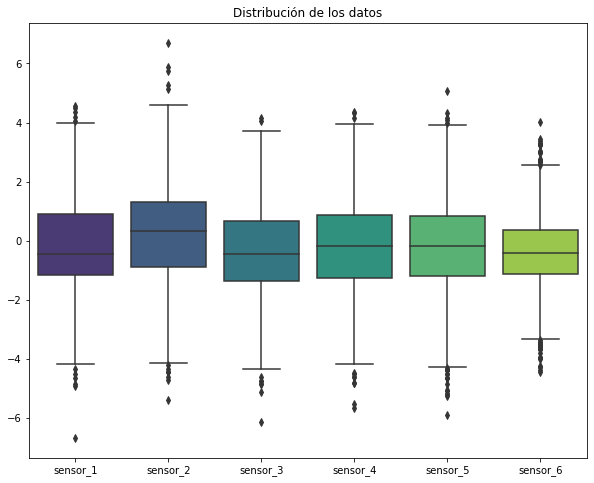

In [7]:
plt.figure(figsize = (10, 8))
sns.boxplot(data = features, palette = "viridis").set(title = "Distribución de los datos")
plt.show()

La gráfica muestra que la mitad de los datos cae en un rango de -1 a 1 aproximadamente pero también hay bastantes valores atípicos en todos los casos. Por esta razón, se van a aplicar métodos de estandarización que no sean tan sensibles a outliers. Se probarán varios métodos para veriguar cuál aporta el mejor resultado para este dataset: RobustScaler, PowerTransformer Yeo-Johnson, y QuantileTransformer uniforme y normal.

También se dividirán los datos en train y test, lo que ayudará a la hora de seleccionar tanto el método de ingeniería de variables adecuado, como el modelo en sí.

In [19]:
#split into test and train
X_train, X_test, y_train, y_test = train_test_split(features, df.target, test_size = 0.3, random_state = 8)

In [25]:
#RobustScaler
rs = RobustScaler(quantile_range = (25, 75)).fit_transform(X_train)

#PowerTransformer Yeo-Johnson
yj = PowerTransformer(method = "yeo-johnson").fit_transform(X_train)

#QuantileTransformer uniform
qtu = QuantileTransformer(output_distribution = "uniform").fit_transform(X_train)

#QuantileTransformer normal
qtn = QuantileTransformer(output_distribution = "normal").fit_transform(X_train)

In [ ]:
data = {}
results = pd.DataFrame(data, )

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Daily closing prices", fontsize=18, y=0.95)

for n, i in enumerate(results):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)
    

In [24]:
fig = plt.figure(figsize = (11, 4))

ax1 = fig.add_subplot(1, 3, 1)

for i in df:
    pca = PCA().fit(norm)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker = "o")
    plt.axhline(0.95, color = "r", linestyle = "--")
    plt.xlim([0, 10])
    plt.xlabel("Número de componentes")
    plt.ylabel("Varianza acumulada explicada")
    plt.show()


NameError: name 'norm' is not defined